# Build a P-Value Interpreter Function with ChatGPT

In [1]:
def interpret_p_value(p_value, threshold=0.05):
    """
    Interpret the p-value in a statistical context against a specific threshold.

    Parameters:
    p_value (float): The p-value to interpret, expected to be in the range 0 to 1.
    threshold (float): The significance level threshold, default is 0.05.

    Returns:
    None: Prints the interpretation of the p-value.

    Raises:
    ValueError: If the p_value or threshold is not within the range [0, 1].

    Description:
    This function assesses the provided p-value against a given threshold:
    - p < threshold: Evidence suggests rejecting the null hypothesis.
    - p >= threshold: Not enough evidence to reject the null hypothesis.

    It's important to note that the interpretation of p-values is context-dependent
    and should be considered along with other factors in statistical analysis.
    """
    if not (0 <= p_value <= 1):
        raise ValueError("p_value must be between 0 and 1.")
    if not (0 <= threshold <= 1):
        raise ValueError("threshold must be between 0 and 1.")

    if p_value < threshold:
        print(f"p-value ({p_value}) is less than the threshold ({threshold}).")
        print("Evidence suggests rejecting the null hypothesis.")
    else:
        print(f"p-value ({p_value}) is greater than or equal to the threshold ({threshold}).")
        print("Not enough evidence to reject the null hypothesis.")

# Example usage
interpret_p_value(0.03, threshold=0.05)

p-value (0.03) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


# Libraries and Data

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [3]:
# Load the data
# Amazon landing page A/B testing data
df = pd.read_csv('amazon_landing_page.csv')
df.head()

,user_id,group,landing_page,converted
0,851104,control,old_page,0
1,804228,control,old_page,0
2,661590,treatment,new_page,0
3,853541,treatment,new_page,0
4,864975,control,old_page,1


In [4]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   group         294480 non-null  object
 2   landing_page  294480 non-null  object
 3   converted     294480 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.0+ MB


# Exploratory Data Analysis (EDA)

#### 1. Descriptive Statistics and Data Quality Check

In [5]:
desc_stats = df.describe()
print(desc_stats)
print(f"\nMissing values in each column:\n{df.isnull().sum()}")
print(f"\nNumber of duplicate entries: {df.duplicated().sum()}")

             user_id      converted
count  294480.000000  294480.000000
mean   787973.538896       0.119658
std     91210.917091       0.324562
min    630000.000000       0.000000
25%    709031.750000       0.000000
50%    787932.500000       0.000000
75%    866911.250000       0.000000
max    945999.000000       1.000000

Missing values in each column:
user_id         0
group           0
landing_page    0
converted       0
dtype: int64

Number of duplicate entries: 2


In [6]:
# Checking consistency between group and landing page
# This verifies if all entries where 'group' is 'control' have 'landing_page' set to 'old_page'
consistency_check = (df['group'] == 'control') == (df['landing_page'] == 'old_page')
print(f"\nConsistency between group and landing page: {consistency_check.all()}")


Consistency between group and landing page: False


#### 2. Group Analysis

In [7]:
group_conversion = df.groupby('group')['converted'].mean()
print(f"\nConversion rate by group:\n{group_conversion}")


Conversion rate by group:
group
control      0.120399
treatment    0.118918
Name: converted, dtype: float64


#### 3. Conversion Rate Analysis

In [8]:
conversion_rate = df['converted'].mean()
print(f"\nOverall conversion rate: {conversion_rate}")


Overall conversion rate: 0.1196583808747623


#### 4. Distribution

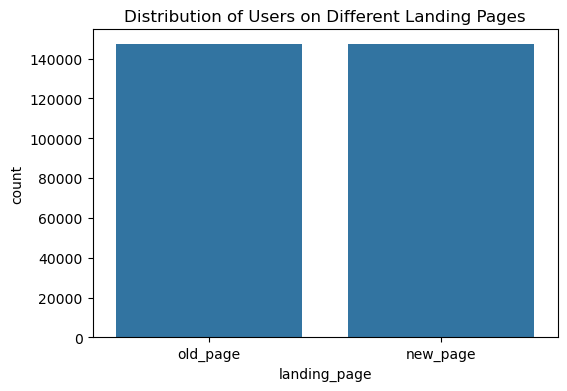

In [9]:
# Plot the count of users for each landing page to visualise the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='landing_page', data=df)
plt.title('Distribution of Users on Different Landing Pages')
plt.show();

# Data Preprocessing

In [10]:
# Removing duplicate entries for user_id
df_unique = df.drop_duplicates(subset='user_id')

In [11]:
# Checking for inconsistencies between group and landing_page

# Identify entries where the 'group' and 'landing_page' values do not match the expected assignment
# 'control' group should have 'old_page' and 'treatment' group should have 'new_page'
inconsistencies = df_unique[((df_unique['group'] == 'control') & (df_unique['landing_page'] != 'old_page')) |
                            ((df_unique['group'] == 'treatment') & (df_unique['landing_page'] != 'new_page'))]

# Counting the nummber of inconsistencies
num_inconsistencies = inconsistencies.shape[0]
print(f"Number of inconsistencies: {num_inconsistencies}")

Number of inconsistencies: 2044


In [12]:
# Option 1: Remove the inconsistent rows
df_fixed = df_unique.drop(inconsistencies.index)

# Bayesian A/B Testing

<span style="color: red">**Note**:<span>

Had to install `tensorflow` with pip (pip3 install tensorflow)
Then install `tensorflow-probability` and `tf-keras` with conda (conda install tensorflow-probability tf-keras)

<span style='color: red'>**Superceded**</span>
Created a new conda environment with Python 3.10 and installed packages with conda and everything worked.
Ref: ChatGPT

In [13]:
# Import libraries
import tensorflow as tf
import tensorflow_probability as tfp

# Alias the distribution module from TensorFlow Probability for easier access
tfd = tfp.distributions

In [14]:
# Get the total conversions and total observations for each group
conversions_A = df_fixed[(df_fixed['group'] == 'control') & (df_fixed['converted'] == 1)].shape[0]
conversions_B = df_fixed[(df_fixed['group'] == 'treatment') & (df_fixed['converted'] == 1)].shape[0]
total_A = df_fixed[(df_fixed['group'] == 'control')].shape[0]
total_B = df_fixed[(df_fixed['group'] == 'treatment')].shape[0]

In [15]:
# Define the prior distributions for the conversion rates
# It is uncommon to go above 10
alpha_prior = 1
beta_prior = 10

In [16]:
# Posterior
posterior_A = tfd.Beta(conversions_A + alpha_prior,
                       total_A - conversions_A + beta_prior)
posterior_B = tfd.Beta(conversions_B + alpha_prior,
                       total_B - conversions_B + beta_prior)

In [17]:
# Sampling from the posteriors
num_samples = 10000
samples_A = posterior_A.sample(num_samples)
samples_B = posterior_B.sample(num_samples)

In [18]:
# Calculate the probability that B is better than A
prob_B_better_than_A = tf.reduce_mean(tf.cast(samples_B > samples_A,
                                              dtype=tf.float32))
print(f"Probability that B is better than A is {prob_B_better_than_A.numpy()}")

Probability that B is better than A is 0.09870000183582306


### Proportions Test with ChatGPT

**Null Hypothesis**: There is no difference between groups

**Alternative Hypothesis**: There is a difference between groups

In [19]:
# Proportions test
import statsmodels.stats.proportion as proportion

# Perform a two-sample z-test for proportions
z_value, p_value = proportion.proportions_ztest([conversions_A, conversions_B],
                                                [total_A, total_B],
                                                alternative='two-sided')

# Interpret the p-value from the test to determine the statistical significance
interpret_p_value(p_value, threshold=0.05)

p-value (0.19534709281210638) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


In [20]:
# Perform a one-sided z-test for proportions
z_value, p_value = proportion.proportions_ztest([conversions_A, conversions_B],
                                                [total_A, total_B],
                                                alternative='larger')

# Interpret the p-value from the test to determine the statistical significance
interpret_p_value(p_value, threshold=0.05)

p-value (0.09767354640605319) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


# Sequential Testing and Early Stopping

In [21]:
# Simulate Experiments
n_experiments = 1000 # Number of experiments to simulate
n_weeks = 5 # Number of weeks each experiment runs
n_per_week = 500 # Number of participants per week in each experiment
cr_control = 0.12
cr_treatment = 0.11

In [24]:
# Running the simulations
early_stopping_results = []

# Simulate for each experiment
for _ in range(n_experiments):
    
    # Simulate data
    control_group = np.random.binomial(1,
                                       cr_control,
                                       n_per_week * n_weeks)
    treatment_group = np.random.binomial(1,
                                         cr_treatment,
                                         n_per_week * n_weeks)
    
    # Sequentially analyse each week
    for week in range(1, n_weeks + 1):
        
        # Slide the data up to n week
        control_data = control_group[:week * n_per_week]
        treatment_data = treatment_group[:week * n_per_week]
        
        # Prepare data for proportions test
        z_value, p_value = proportion.proportions_ztest(
            [control_data.sum(), treatment_data.sum()],
            [len(control_data), len(treatment_data)])
        
        # Perform the test
        
        # Check if result is significant
        if p_value < 0.05:
            early_stopping_results.append((week, p_value))
            break
        else:
            # record the results
            early_stopping_results.append((n_weeks, p_value))

In [25]:
# Check the results
early_stopping_results

[(5, 0.32338892761331783),
 (5, 0.7203137270437967),
 (5, 0.9078226062134492),
 (5, 0.39723242337915443),
 (5, 0.8589406700896141),
 (5, 0.7086338860276755),
 (2, 0.04716305148097217),
 (5, 0.19064530465523333),
 (5, 0.21593078502928598),
 (5, 0.1801496748942557),
 (5, 0.33553786458275703),
 (5, 0.11048086330484495),
 (5, 0.17615211523948004),
 (5, 0.14625315632628508),
 (5, 0.43263655090530784),
 (5, 0.26094149031127534),
 (5, 0.15883225996872208),
 (5, 0.3828371233517417),
 (5, 0.6839536441272458),
 (5, 0.3652054129175626),
 (5, 0.4869387484099552),
 (5, 0.20422226099093432),
 (5, 0.4877643664856912),
 (5, 0.7758513085447067),
 (5, 0.7262593154474661),
 (5, 0.31313651110187535),
 (5, 0.526218072402653),
 (5, 0.5726296384463159),
 (5, 0.5379059615525206),
 (5, 0.5427553088173107),
 (5, 0.7771614081168727),
 (5, 0.8324887021071312),
 (5, 0.44273313382442325),
 (5, 0.8400700381691026),
 (5, 0.7858225084094486),
 (5, 0.741461913064812),
 (5, 0.6695674593965489),
 (5, 0.3723300711778993),

In [26]:
# Analyse the results
stopped_weeks, stopped_p_values = zip(*early_stopping_results)
average_stopping_week = np.mean(stopped_weeks)
print(f"The Average Stopping week is {average_stopping_week}")

The Average Stopping week is 4.856358645928637


# A/B/C Tests

In [28]:
# Load the data
df_netflix = pd.read_csv('netflix_wednesday_thumbnail.csv')
df_netflix.head()

,Participant ID,Thumbnail Variant,Watched Show,Minutes Watched
0,1,Thumbnail A,True,25
1,2,Thumbnail B,False,0
2,3,Thumbnail A,False,0
3,4,Thumbnail B,False,0
4,5,Thumbnail B,True,46


#### 1. Descriptive Statistics

In [29]:
df_netflix.describe()

,Participant ID,Minutes Watched
count,20000.000000,20000.000000
mean,10000.500000,15.179150
std,5773.647028,19.285418
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,1.000000
75%,15000.250000,31.000000
max,20000.000000,59.000000


#### 2. Distribution Analysis

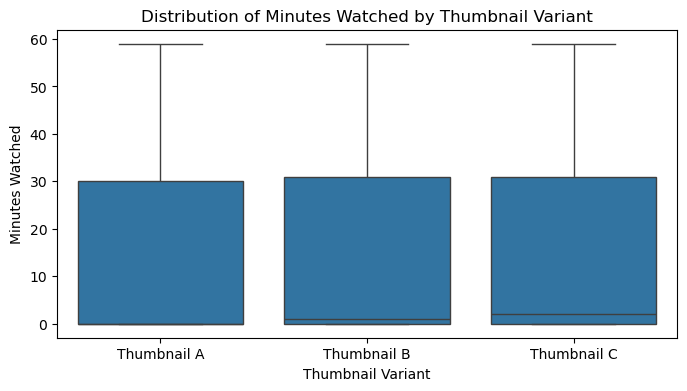

In [30]:
# Create a boxplot to visualise the distribution of 'Minutes Watched' by 'Thumbnail Variant'
plt.figure(figsize=(8, 4))
sns.boxplot(x='Thumbnail Variant', y='Minutes Watched', data=df_netflix)
plt.title('Distribution of Minutes Watched by Thumbnail Variant')
plt.show();

In [31]:
# Calculate the proportion of users who watched the show, grouped by 'Thumbnail Variant'
watched_show_proportion = df_netflix.groupby('Thumbnail Variant')['Watched Show'].mean()
print(watched_show_proportion)

Thumbnail Variant
Thumbnail A    0.494050
Thumbnail B    0.503876
Thumbnail C    0.508342
Name: Watched Show, dtype: float64


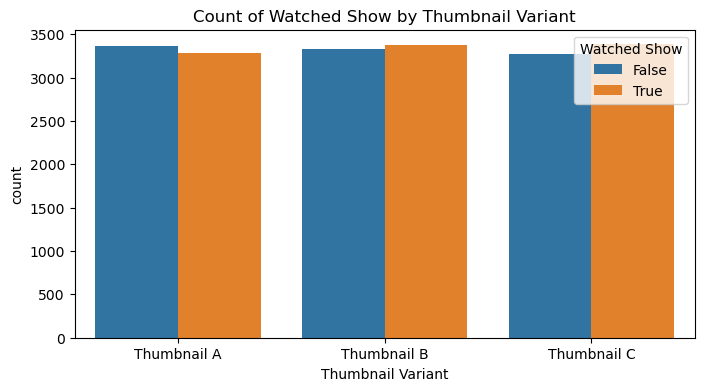

In [32]:
# Visualisation of Watched Show and Thumbnail Variant

# Create a count plot to show the number of users who watched or did not watch the show, grouped by 'Thumbnail Variant'
plt.figure(figsize=(8, 4))
sns.countplot(x='Thumbnail Variant', hue='Watched Show', data=df_netflix)
plt.title('Count of Watched Show by Thumbnail Variant')
plt.show();